# "Next Generation Reservoir Computing"

Daniel J. Gauthier, Erik Bollt, Aaron Grifﬁth & Wendson A. S. Barbosa


*Nature Communications*, vol. 12, no. 1, p. 5564, Sep. 2021, doi: 10.1038/s41467-021-25801-2.


In [20]:
import matplotlib.pyplot as plt
import numpy as np

from reservoirpy.datasets import lorenz, doublescroll
from reservoirpy.nodes import Ridge, NVAR

## Abstract

Reservoir computing is a best-in-class machine learning algorithm for processing information
generated by dynamical systems using observed time-series data. Importantly, it requires
very small training data sets, uses linear optimization, and thus requires minimal computing
resources. However, the algorithm uses randomly sampled matrices to deﬁne the underlying
recurrent neural network and has a multitude of metaparameters that must be optimized.
Recent results demonstrate the equivalence of reservoir computing to nonlinear vector
autoregression, which requires no random matrices, fewer metaparameters, and provides
interpretable results. Here, we demonstrate that nonlinear vector autoregression excels at
reservoir computing benchmark tasks and requires even shorter training data sets and
training time, heralding the next generation of reservoir computing.


## Implementation using *ReservoirPy*

This notebook is provided as a demo of the `NVAR` node in ReservoirPy, implementing the method described in the paper *Next Generation Reservoir Computing* by Gauthier *et al.*

The nonlinear vector autoregressive (NVAR) machine implements the following equations. The state $\mathbf{O}_{total}$ of the NVAR first contains a serie of linear features $\mathbf{O}_{lin}$ made of input data concatenated with delayed inputs:

$$
\mathbf{O}_{lin}[t] = \mathbf{X}[t] \oplus \mathbf{X}[t - s] \oplus \mathbf{X}[t - 2s] \oplus \dots \oplus \mathbf{X}[t - (k-1)s]
$$

where $\mathbf{X}[t]$ are the inputs at time $t$, $k$ is the delay and $s$ is the strides (only one input every $s$ inputs within the delayed inputs is used). The operator $\oplus$ denotes the concatenation.

In addition to these linear features, nonlinear representations $\mathbf{O}_{nonlin}^n$ of the inputs are contructed using all unique monomials of order $n$ of these inputs:

$$
\mathbf{O}_{nonlin}^n[t] = \mathbf{O}_{lin}[t] \otimes \mathbf{O}_{lin}[t] \overbrace{\otimes \dots \otimes}^{n-1~\mathrm{times}} \mathbf{O}_{lin}[t]
$$

where $\otimes$ is the operator denoting an outer product followed by the selection of all unique monomials generated by this outer product. Under the hood, this product is computed by ReservoirPy by finding all unique combinations of input features and multiplying each combination of terms.

Finally, all representations are gathered to form the final feature vector $\mathbf{O}_{total}$:

$$
\mathbf{O}_{total} = \mathbf{O}_{lin}[t] \oplus \mathbf{O}_{nonlin}^n[t]
$$

Tikhonov regression is used to compute the readout weights using this feature vector and some target values, in an offline way (we will simply use ReservoirPy's `Ridge` node of for this).

## 1. NVAR for Lorenz strange attractor forecating

In [21]:
dt = 0.025
train_time  = 10.
test_time   = 120.
warm_time   = 5.
train_steps = round(train_time / dt)
test_steps  = round(test_time  / dt)
warm_steps  = round(warm_time  / dt)

In [22]:
x0 = [17.67715816276679, 12.931379185960404, 43.91404334248268]
n_timesteps = train_steps + test_steps + warm_steps

X = lorenz(n_timesteps, x0=x0, h=dt, method="RK23")

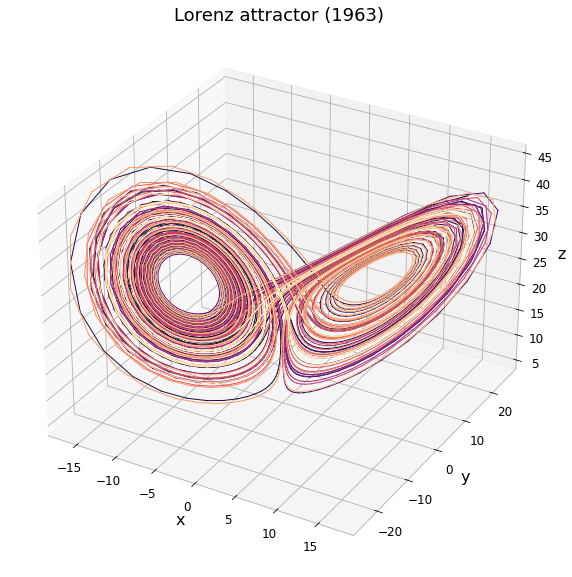

In [26]:
N = train_steps + warm_steps + test_steps

fig = plt.figure(figsize=(10, 10))
ax  = fig.add_subplot(111, projection='3d')
ax.set_title("Lorenz attractor (1963)")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

for i in range(N-1):
    ax.plot(X[i:i+2, 0], X[i:i+2, 1], X[i:i+2, 2], color=plt.cm.magma(255*i//N), lw=1.0)

plt.show()

In [5]:
nvar = NVAR(2, 2)
readout = Ridge(3, ridge=2.5e-6)

model = nvar >> readout

In [6]:
nvar.run(X[:warm_steps-1])
model = model.fit(X[warm_steps-1:train_steps+warm_steps-1], X[warm_steps:train_steps+warm_steps])

In [7]:
nvar.run(X[:warm_steps-1])
res = model.run(X[warm_steps-1:train_steps+warm_steps-1])

In [8]:
lin = ["$x_t$", "$y_t$", "$z_t$", "$x_{t-1}$", "$y_{t-1}$", "$z_{t-1}$"]

nonlin = []
for idx in nvar._monomial_idx:
    if idx[0] == idx[1]:
        c = lin[idx[0]][:-1] + "^2$"
    else:
        c = " ".join((lin[idx[0]], lin[idx[1]]))
        
    nonlin.append(c)
    
coefs = ["c"] + lin + nonlin

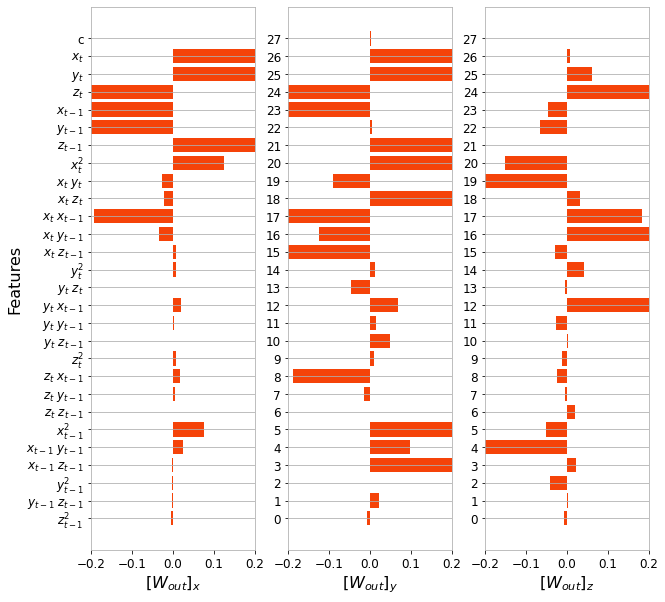

In [9]:
fig = plt.figure(figsize=(10, 10))

Wout = np.r_[readout.bias, readout.Wout]
x_Wout, y_Wout, z_Wout = Wout[:, 0], Wout[:, 1], Wout[:, 2]

ax = fig.add_subplot(131)
ax.set_xlim(-0.2, 0.2)
ax.grid(axis="y")
ax.set_xlabel("$[W_{out}]_x$")
ax.set_ylabel("Features")
ax.set_yticks(np.arange(len(coefs)))
ax.set_yticklabels(coefs[::-1])
ax.barh(np.arange(x_Wout.size), x_Wout.ravel()[::-1])

ax1 = fig.add_subplot(132)
ax1.set_xlim(-0.2, 0.2)
ax1.grid(axis="y")
ax1.set_yticks(np.arange(len(coefs)))
ax1.set_xlabel("$[W_{out}]_y$")
ax1.barh(np.arange(y_Wout.size), y_Wout.ravel()[::-1])

ax2 = fig.add_subplot(133)
ax2.set_xlim(-0.2, 0.2)
ax2.grid(axis="y")
ax2.set_yticks(np.arange(len(coefs)))
ax2.set_xlabel("$[W_{out}]_z$")
ax2.barh(np.arange(z_Wout.size), z_Wout.ravel()[::-1])

plt.show()

In [10]:
nvar.run(X[warm_steps+train_steps-2:warm_steps+train_steps])
u = X[warm_steps+train_steps]
res = np.zeros((test_steps, readout.output_dim))
for i in range(test_steps):
    u = model(u)
    res[i, :] = u

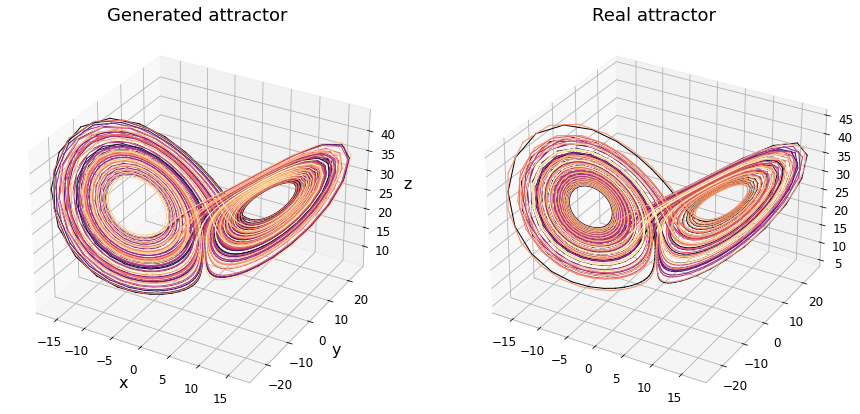

In [11]:
N = test_steps
Y = X[warm_steps+train_steps:]

fig = plt.figure(figsize=(15, 10))
ax  = fig.add_subplot(121, projection='3d')
ax.set_title("Generated attractor")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

for i in range(N-1):
    ax.plot(res[i:i+2, 0], res[i:i+2, 1], res[i:i+2, 2], color=plt.cm.magma(255*i//N), lw=1.0)
    
ax2 = fig.add_subplot(122, projection='3d')
ax2.set_title("Real attractor")

for i in range(N-1):
    ax2.plot(Y[i:i+2, 0], Y[i:i+2, 1], Y[i:i+2, 2], color=plt.cm.magma(255*i//N), lw=1.0)

## 2. NVAR for double scroll strange attractor forecasting

In [27]:
dt = 0.25
train_time  = 100.
test_time   = 800.
warm_time   = 1.
train_steps = round(train_time / dt)
test_steps  = round(test_time  / dt)
warm_steps  = round(warm_time  / dt)

In [28]:
x0 = [0.37926545, 0.058339, -0.08167691]
n_timesteps = train_steps + test_steps + warm_steps

X = doublescroll(n_timesteps, x0=x0, h=dt, method="RK23")

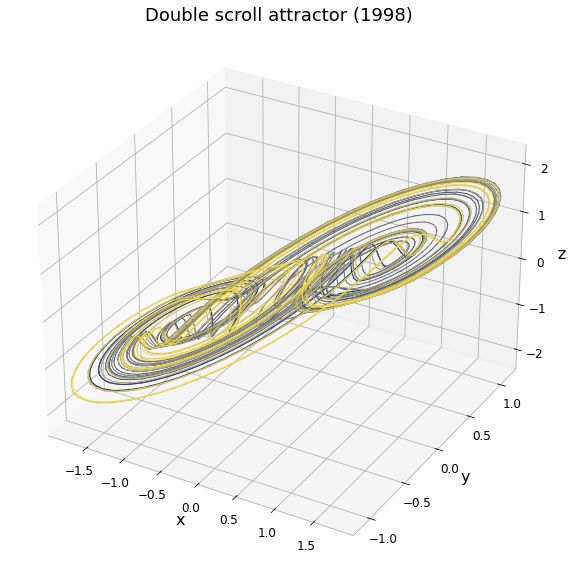

In [30]:
N = train_steps + warm_steps + test_steps

fig = plt.figure(figsize=(10, 10))
ax  = fig.add_subplot(111, projection='3d')
ax.set_title("Double scroll attractor (1998)")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

for i in range(N-1):
    ax.plot(X[i:i+2, 0], X[i:i+2, 1], X[i:i+2, 2], color=plt.cm.cividis(255*i//N), lw=1.0)

plt.show()